In [ ]:
# Imports básicos
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine Learning
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import (
    silhouette_score, 
    silhouette_samples,
    calinski_harabasz_score, 
    davies_bouldin_score
)
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# NLP y Embeddings
from sentence_transformers import SentenceTransformer

# Reducción dimensional
import umap

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Imports completados")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Imports completados
Python version: 3.13.7 (main, Aug 14 2025, 00:00:00) [GCC 15.2.1 20250808 (Red Hat 15.2.1-1)]
NumPy version: 2.3.3
Pandas version: 2.3.3


In [ ]:
# Configurar Django para acceder a modelos
import django

# Añadir ruta del proyecto
project_path = Path.cwd()
sys.path.insert(0, str(project_path))

# Configurar settings
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'config.settings')
django.setup()
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
# Importar modelos
from apps.documents.models import Document

print("Django configurado")
print(f"Total documentos en BD: {Document.objects.count()}")

Django configurado
Total documentos en BD: 323


In [ ]:
# METODOLOGÍA EXACTA del servicio web (clustering_service.py líneas 387-395)
# Filtrar por:
# 1. status='processed' 
# 2. summary_embedding no nulo
# 3. Ordenar por fecha de creación descendente
# 4. Limitar a max_documents (230 para replicar el análisis exitoso)

max_documents = 230

documents = Document.objects.filter(
    status='processed',
    summary_embedding__isnull=False
).prefetch_related(
    'document_persons__person',
    'legal_area',
    'doc_type'
).order_by('-created_at')[:max_documents]

print(f"📊 Documentos filtrados (status='processed' + summary_embedding): {documents.count()}")

# Convertir a DataFrame y extraer embeddings PRE-CALCULADOS
data = []
embeddings_list = []

for doc in documents:
    data.append({
        'id': doc.document_id,
        'title': doc.title,
        'summary': doc.summary,
        'legal_area': doc.legal_area.name if doc.legal_area else 'Sin clasificar',
        'doc_type': doc.doc_type.name if doc.doc_type else 'Sin tipo',
        'case_number': doc.case_number,
        'created_at': doc.created_at
    })
    # Usar embeddings PRE-CALCULADOS (NO generarlos nuevamente)
    embeddings_list.append(np.array(doc.summary_embedding))

df = pd.DataFrame(data)
embeddings = np.array(embeddings_list, dtype=np.float64)

print("\nInformación del DataFrame:")
print(df.info())
print(f"\nShape de embeddings: {embeddings.shape}")
print("\nDistribución por área legal:")
print(df['legal_area'].value_counts())
print("\nDistribución por tipo de documento:")
print(df['doc_type'].value_counts())

📊 Documentos filtrados (status='processed' + summary_embedding): 230

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   id           230 non-null    object             
 1   title        230 non-null    object             
 2   summary      230 non-null    object             
 3   legal_area   230 non-null    object             
 4   doc_type     230 non-null    object             
 5   case_number  216 non-null    object             
 6   created_at   230 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(6)
memory usage: 12.7+ KB
None

Shape de embeddings: (230, 384)

Distribución por área legal:
legal_area
Penal                         76
Laboral                       57
Contencioso Administrativo    39
Familia Civil                 37
Civil                         16
Fami


=== Starting PCA → UMAP → HDBSCAN Pipeline ===

PCA shape: (230, 50)


/home/vicari/Downloads/PROJECTS/python-projects/poder-judicial-project/backup-pj-no-similarity/poder-judicial-docs/.venv/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP (10D) shape: (230, 10)

Clusters found: 8
Noise points:   21

=== Metrics ===
Silhouette score:          0.4883
Calinski-Harabasz:         344.2184
Davies-Bouldin (lower=good): 1.0952


/home/vicari/Downloads/PROJECTS/python-projects/poder-judicial-project/backup-pj-no-similarity/poder-judicial-docs/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vicari/Downloads/PROJECTS/python-projects/poder-judicial-project/backup-pj-no-similarity/poder-judicial-docs/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vicari/Downloads/PROJECTS/python-projects/poder-judicial-project/backup-pj-no-similarity/poder-judicial-docs/.venv/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



2D UMAP completed.


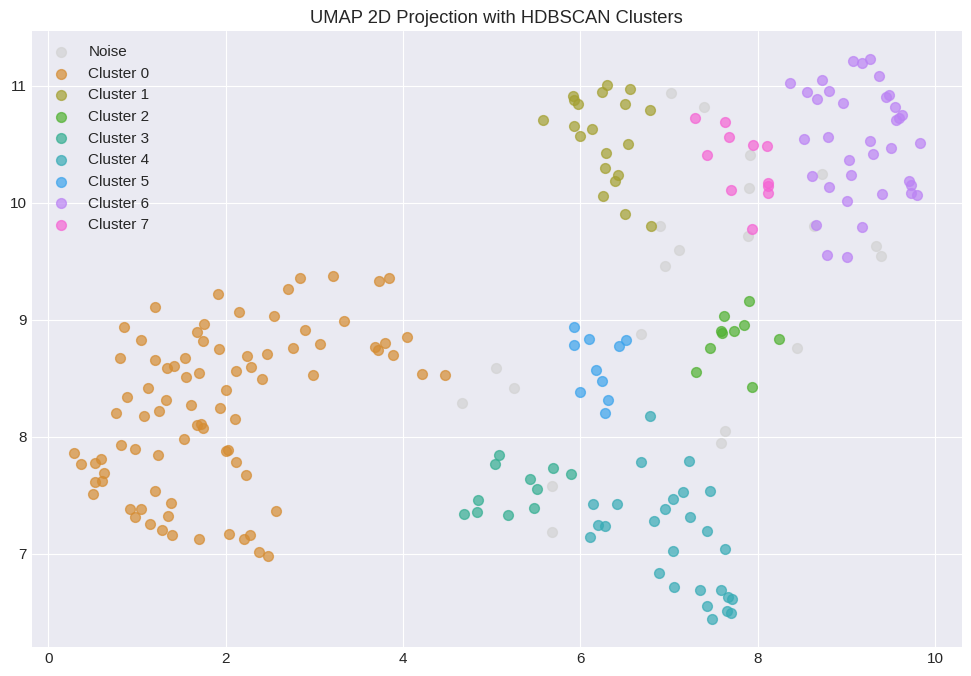


Pipeline finished successfully.


In [ ]:
from sklearn.decomposition import PCA
import hdbscan

print("\n=== Starting PCA → UMAP → HDBSCAN Pipeline ===\n")

# ---------------------------
# STEP 1 — PCA (denoise & stabilize)
# ---------------------------
pca_components = 50  # good default for 384-D embeddings
pca = PCA(n_components=pca_components, random_state=42)
X_pca = pca.fit_transform(embeddings)

print(f"PCA shape: {X_pca.shape}")


# ---------------------------
# STEP 2 — UMAP (for clustering)
# ---------------------------
umap_cluster = umap.UMAP(
    n_components=10,
    n_neighbors=15,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

X_umap = umap_cluster.fit_transform(X_pca)
print(f"UMAP (10D) shape: {X_umap.shape}")


# ---------------------------
# STEP 3 — HDBSCAN
# ---------------------------
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=8,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='eom'
)

labels = clusterer.fit_predict(X_umap)
df['cluster'] = labels

n_clusters = len(set(labels) - {-1})
n_noise = np.sum(labels == -1)

print(f"\nClusters found: {n_clusters}")
print(f"Noise points:   {n_noise}")


# ---------------------------
# STEP 4 — Cluster metrics
# ---------------------------
if n_clusters > 1:
    sil = silhouette_score(X_umap, labels)
    ch = calinski_harabasz_score(X_umap, labels)
    dbs = davies_bouldin_score(X_umap, labels)

    print("\n=== Metrics ===")
    print(f"Silhouette score:          {sil:.4f}")
    print(f"Calinski-Harabasz:         {ch:.4f}")
    print(f"Davies-Bouldin (lower=good): {dbs:.4f}")
else:
    print("\n⚠ Metrics skipped: <2 clusters found")


# ---------------------------
# STEP 5 — UMAP 2D (visualization)
# ---------------------------
umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

X_2d = umap_2d.fit_transform(X_pca)
df['x'] = X_2d[:, 0]
df['y'] = X_2d[:, 1]

print("\n2D UMAP completed.")


# ---------------------------
# STEP 6 — Plot 2D cluster map
# ---------------------------
plt.figure(figsize=(12, 8))
unique_labels = sorted(set(labels))

# Colormap
palette = sns.color_palette("husl", len(unique_labels))

for idx, label in enumerate(unique_labels):
    mask = labels == label
    color = palette[idx] if label != -1 else "lightgray"
    name = f"Cluster {label}" if label != -1 else "Noise"

    plt.scatter(
        df.loc[mask, 'x'],
        df.loc[mask, 'y'],
        label=name,
        alpha=0.7,
        s=50,
        c=[color]
    )

plt.title("UMAP 2D Projection with HDBSCAN Clusters")
plt.legend()
plt.show()

print("\nPipeline finished successfully.")


In [ ]:
print(df.groupby('cluster')['legal_area'].value_counts(normalize=True))


cluster  legal_area                
-1       Laboral                       0.523810
         Familia Civil                 0.190476
         Contencioso Administrativo    0.142857
         Penal                         0.095238
         Civil                         0.047619
 0       Penal                         0.833333
         Familia Civil                 0.107143
         Familia Penal                 0.023810
         Familia Tutelar               0.023810
         Laboral                       0.011905
 1       Contencioso Administrativo    0.500000
         Laboral                       0.450000
         Penal                         0.050000
 2       Laboral                       0.700000
         Civil                         0.100000
         Contencioso Administrativo    0.100000
         Familia Civil                 0.100000
 3       Familia Civil                 0.909091
         Contencioso Administrativo    0.090909
 4       Civil                         0.481481
    

# UMAP-> HDBSCAN -> UMAP

=== Starting UMAP → HDBSCAN → UMAP2 Pipeline ===


/home/vicari/Downloads/PROJECTS/python-projects/poder-judicial-project/backup-pj-no-similarity/poder-judicial-docs/.venv/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP (50D) shape: (230, 30)

Clusters found: 16
Noise points:   26

=== Metrics ===
Silhouette score:          0.3543991446495056
Calinski-Harabasz:         346.0845947265625
Davies-Bouldin (lower=good): 0.8705883448728033

2D UMAP completed.


/home/vicari/Downloads/PROJECTS/python-projects/poder-judicial-project/backup-pj-no-similarity/poder-judicial-docs/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vicari/Downloads/PROJECTS/python-projects/poder-judicial-project/backup-pj-no-similarity/poder-judicial-docs/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vicari/Downloads/PROJECTS/python-projects/poder-judicial-project/backup-pj-no-similarity/poder-judicial-docs/.venv/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


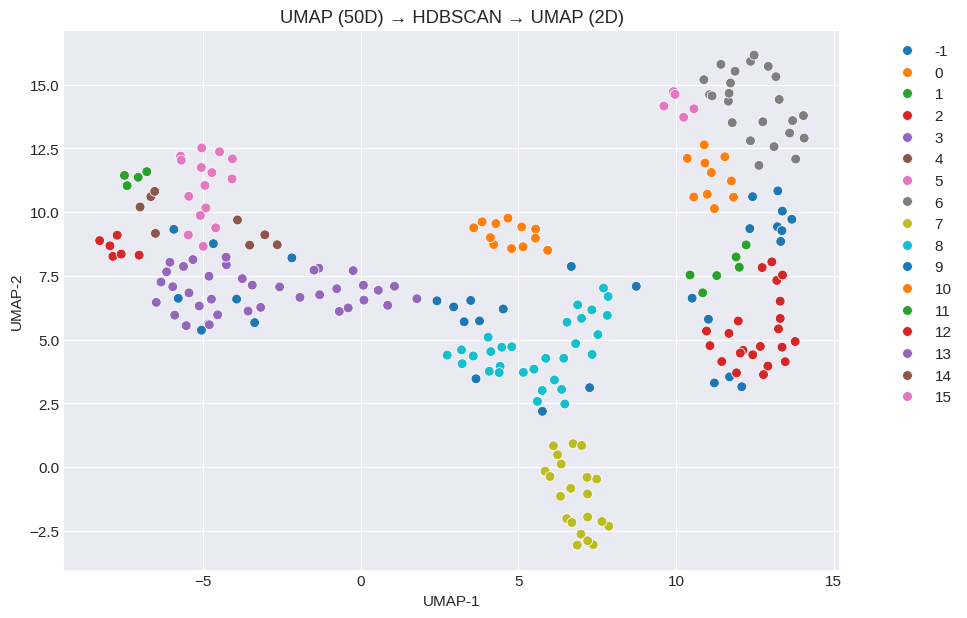

In [ ]:
import numpy as np
import pandas as pd
import umap
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# CONFIG
# ============================================================

REDUCE_DIMS = 30   # First UMAP projection
SEED = 42

print("=== Starting UMAP → HDBSCAN → UMAP2 Pipeline ===")

# ============================================================
# 1️⃣ UMAP #1 (384D → 50D)
# ============================================================

umap_1 = umap.UMAP(
    n_components=REDUCE_DIMS,
    n_neighbors=15,
    min_dist=0.0,
    metric='cosine',
    random_state=SEED
)

embeddings_50d = umap_1.fit_transform(embeddings)
print(f"UMAP (50D) shape: {embeddings_50d.shape}")

# ============================================================
# 2️⃣ HDBSCAN (on 50D space)
# ============================================================

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=4,
    min_samples=2,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

cluster_labels = clusterer.fit_predict(embeddings_50d)

df["cluster"] = cluster_labels


n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
noise_points = np.sum(cluster_labels == -1)

print(f"\nClusters found: {n_clusters}")
print(f"Noise points:   {noise_points}")

# ============================================================
# 3️⃣ Metrics (ignore label -1 for silhouette)
# ============================================================

mask = cluster_labels != -1

if n_clusters > 1 and mask.sum() > 10:
    sil = silhouette_score(embeddings_50d[mask], cluster_labels[mask])
    ch = calinski_harabasz_score(embeddings_50d[mask], cluster_labels[mask])
    db = davies_bouldin_score(embeddings_50d[mask], cluster_labels[mask])
else:
    sil, ch, db = None, None, None

print("\n=== Metrics ===")
print(f"Silhouette score:          {sil}")
print(f"Calinski-Harabasz:         {ch}")
print(f"Davies-Bouldin (lower=good): {db}")

# ============================================================
# 4️⃣ UMAP #2 (Visualization 2D)
# ============================================================

umap_2 = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    min_dist=0.0,
    metric='euclidean',
    random_state=SEED
)

embeddings_2d = umap_2.fit_transform(embeddings_50d)

print("\n2D UMAP completed.")

# ============================================================
# 5️⃣ Visualization
# ============================================================

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=cluster_labels,
    palette='tab10',
    s=50
)
plt.title("UMAP (50D) → HDBSCAN → UMAP (2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
df.groupby('cluster')['legal_area'].value_counts(normalize=True)


cluster  legal_area                
-1       Penal                         0.538462
         Laboral                       0.153846
         Contencioso Administrativo    0.115385
         Civil                         0.076923
         Familia Civil                 0.076923
         Familia Penal                 0.038462
 0       Laboral                       0.666667
         Contencioso Administrativo    0.166667
         Civil                         0.083333
         Penal                         0.083333
 1       Penal                         1.000000
 2       Penal                         1.000000
 3       Penal                         0.750000
         Familia Civil                 0.250000
 4       Penal                         1.000000
 5       Contencioso Administrativo    0.600000
         Laboral                       0.400000
 6       Laboral                       0.521739
         Contencioso Administrativo    0.434783
         Civil                         0.043478
 7  

In [ ]:
# from sklearn.preprocessing import normalize

# # emb_norm = normalize(embeddings, norm='l2')
# emb_norm = embeddings


In [ ]:
# import hdbscan

# # Normalize embeddings
# from sklearn.preprocessing import normalize
# # emb_norm = normalize(embeddings)

# # clusterer = hdbscan.HDBSCAN(
# #     metric='euclidean',
# #     min_cluster_size=2,
# #     min_samples=2
# # )

# clusterer = DBSCAN(
#     eps=0.135,
#     min_samples=4,
#     metric='cosine'
# )

# labels = clusterer.fit_predict(emb_norm)



In [ ]:
unique, counts = np.unique(labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Clusters encontrados:", cluster_summary)


Clusters encontrados: {np.int64(-1): np.int64(21), np.int64(0): np.int64(84), np.int64(1): np.int64(20), np.int64(2): np.int64(10), np.int64(3): np.int64(11), np.int64(4): np.int64(27), np.int64(5): np.int64(10), np.int64(6): np.int64(36), np.int64(7): np.int64(11)}


In [ ]:
# core_points = labels != -1
# if len(np.unique(labels[core_points])) > 1:
#     sil = silhouette_score(emb_norm[core_points], labels[core_points], metric='cosine')
#     db = davies_bouldin_score(emb_norm[core_points], labels[core_points])
#     ch = calinski_harabasz_score(emb_norm[core_points], labels[core_points])

#     print(f"Silhouette: {sil:.4f}")
#     print(f"Davies-Bouldin: {db:.4f}")
#     print(f"Calinski-Harabasz: {ch:.4f}")
# else:
#     print("No se pueden calcular métricas: solo hay un cluster o demasiados outliers.")


In [ ]:
# umap_model = umap.UMAP(
#     n_components=2,
#     n_neighbors=15,
#     min_dist=0.1,
#     metric='cosine'
# )

# coords = umap_model.fit_transform(emb_norm)

# plt.figure(figsize=(12, 8))
# sns.scatterplot(
#     x=coords[:, 0],
#     y=coords[:, 1],
#     hue=labels,
#     palette="tab20",
#     s=50
# )
# plt.title("Graph")
# plt.show()
